In [19]:
#...imports...

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(42)

### Data

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

full_dataset = torchvision.datasets.MNIST(root='./data', train=True,  download=True, transform=transform)

indices_by_class = [[] for _ in range(10)]

for idx, (_, label) in enumerate(full_dataset):
  indices_by_class[label].append(idx)

valid_indices = []
train_datasets_by_class = []

for class_indices in indices_by_class:

  selected_indices = np.random.choice(class_indices, size=1000, replace=False).tolist()

  # training data
  train_indices = selected_indices[:800]
  np.random.shuffle(train_indices)
  train_subset = Subset(full_dataset, train_indices)
  train_datasets_by_class.append(train_subset)

  # validation data
  valid_indices.extend(selected_indices[800:1000])

v_inputs, v_labels = [], []
for valid_idx in valid_indices:
  image, label = full_dataset[valid_idx]
  v_inputs.append(image)
  v_labels.append(label)

### Model and Generator

In [21]:
def output_length(input_length, kernel_size, padding, stride):
  """Find output dimension of a convolutional layer"""
  return int((input_length - kernel_size + (2 * padding)) / stride + 1)

In [22]:
#...model...

class SimpleCNN(nn.Module):
  def __init__(self, input_channels=3, num_classes=10, image_size=28):
    super(SimpleCNN, self).__init__()

    # convolutional layers
    self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=4, kernel_size=3, stride=1, padding=0)
    self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0)

    # pooling layer
    self.pool  = nn.AvgPool2d(kernel_size=2, stride=2)

    # find the final size that enters the fc layer
    length = output_length(output_length(image_size, 3, 0, 1), 3, 0, 1) // 2
    self.fc_input_size = 8 * length * length

    # fully connected layer
    self.fc = nn.Linear(self.fc_input_size, num_classes)

  def forward(self, x):

    """Design forward pass"""

    # -> conv1 -> relu
    x = F.relu(self.conv1(x))

    # -> conv2 -> relu -> pooling
    x = self.pool(F.relu(self.conv2(x)))

    # flatten for fully connected layer
    x = x.view(-1, self.fc_input_size)

    # -> fc
    x = self.fc(x)

    return x



In [23]:
#...data generator...

class AdaptiveDataGenerator:

  def __init__(self, num_classes=10):
    self.nb_classes = num_classes

    # training data
    self.class_datasets = train_datasets_by_class
    self.class_current_indices = [0 for _ in range(num_classes)]

    # start with all classes equally weighted
    self.class_weights = np.ones(num_classes) / num_classes

  def generate_batch(self, batch_size=100):

    """Generate a batch of data with current class distribution weights"""

    # draw class counts from a multinom distribution for some variation
    class_counts = np.random.multinomial(batch_size, self.class_weights)

    # generate samples for each class
    x_batch, y_batch = [], []
    for label in range(self.nb_classes):
      nb_samples = class_counts[label]

      if nb_samples > 0:

        samples = self._generate_samples_for_class(label, nb_samples)
        labels  = torch.full((nb_samples,), label, dtype=torch.long)

        x_batch.append(samples)
        y_batch.append(labels)

    # combine
    x_combined = torch.cat(x_batch, dim=0)
    y_combined = torch.cat(y_batch, dim=0)

    # shuffle
    indices = torch.randperm(x_combined.shape[0])
    x_combined = x_combined[indices]
    y_combined = y_combined[indices]

    return x_combined, y_combined

  def _generate_samples_for_class(self, label, count):

      """ Generate 'count' samples for the specified class. """

      class_dataset = self.class_datasets[label]
      current_idx = self.class_current_indices[label]

      samples_left = len(class_dataset) - self.class_current_indices[label]
      if count > samples_left:
        raise ValueError(f"Requested {count} samples for label {label} but only {samples_left} remain")

      samples = []
      for i in range(count):
        sample, lab = class_dataset[current_idx + i]

        if lab != label:
          raise ValueError(f"Big big wahala {lab} image in {label} request")

        samples.append(sample)


      self.class_current_indices[label] += count

      return torch.stack(samples)


  def update_class_weights(self, class_accuracies):
        """ Update class weights based on per-class accuracies. Classes with lower accuracy will get higher sampling weights."""

        # invert so (lower accuracy = higher sample weight)
        weights = 1.0 - np.array(class_accuracies)

        # avoid zero weights with small constant
        # why? zero weights = complete elimination = even if performance on this class degrades later, no recovery
        weights += 0.1

        # normalize to create a proper probability distribution
        self.class_weights = weights / weights.sum()

        return self.class_weights

### Common Training Parameters

In [24]:
def evaluate_model(model, inputs, labels, criterion, device):

    """
    Evaluate a model on validation data.
    """
    model.eval()

    with torch.no_grad():
        # inference on validation set
        outputs = model(inputs)
        val_loss = criterion(outputs, labels).item()
        _, predicted = torch.max(outputs, 1)

        # per-class accuracies
        class_accuracies = []
        for c in range(10):  # Assuming 10 classes (MNIST)
            class_mask = (labels == c)  # Boolean mask

            if torch.sum(class_mask) > 0:
                class_accuracy = torch.sum(predicted[class_mask] == c).float() / torch.sum(class_mask)
                class_accuracies.append(class_accuracy.cpu().numpy())
            else:
                class_accuracies.append(0.0)

    return val_loss, class_accuracies, predicted

In [25]:
def train_model(model, optimizer, data_generator, v_inputs, v_labels, criterion, device,
              epochs=20, batches_per_epoch=10, batch_size=20, frequency=1, adaptive=True):

    """
    Train a model with either adaptive or standard training.
    """

    model.to(device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'class_accuracies': [],
        'epochs': []
    }

    if adaptive:
        history['class_weights'] = []

    print(f"Starting {'adaptive' if adaptive else 'standard'} training...")

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        epoch_loss = 0.0

        # process multiple batches per epoch
        for batch in range(batches_per_epoch):

            inputs, labels = data_generator.generate_batch(batch_size=batch_size)
            inputs, labels = inputs.to(device), labels.to(device)

            # training step
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            print(f"  Batch {batch+1}/{batches_per_epoch}, Loss: {loss.item():.4f}")

        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / batches_per_epoch
        print(f"  Epoch Average Loss: {avg_epoch_loss:.4f}")

        # validation step
        if (epoch % frequency) == 0:

            v_loss, class_accuracies, predicted = evaluate_model(model, v_inputs, v_labels, criterion, device)

            # Update class weights if adaptive
            if adaptive:
                new_weights = data_generator.update_class_weights(class_accuracies)
                print(f"Class Accuracies: {[float(f'{acc:.2f}') for acc in class_accuracies]}")
                print(f"New Class Weights: {[float(f'{w:.2f}') for w in new_weights]}")
                history['class_weights'].append(new_weights.tolist())
            else:
                print(f"Class Accuracies: {[float(f'{acc:.2f}') for acc in class_accuracies]}")

            history['epochs'].append(epoch)
            history['train_loss'].append(avg_epoch_loss)
            history['val_loss'].append(v_loss)
            history['class_accuracies'].append(class_accuracies)

            # Set back to training mode
            model.train()

    print(f"{'Adaptive' if adaptive else 'Standard'} training complete!")
    return history

In [26]:
criterion         = nn.CrossEntropyLoss()

epochs            = 20
frequency         = 1 # evaluate and update after every x batches
batch_size        = 20
batches_per_epoch = 10
samples_per_epoch = batch_size * batches_per_epoch

device            = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# convert validation data to tensors
v_inputs = torch.stack(v_inputs, dim=0).to(device)
v_labels = torch.tensor(v_labels, dtype=torch.long).to(device)

### Adaptive Training

In [27]:
#...set up...
print("=== Starting Adaptive Training ===")

cnn            = SimpleCNN(input_channels=1, num_classes=10, image_size=28)
optimizer      = optim.Adam(cnn.parameters(), lr=0.001)
data_generator = AdaptiveDataGenerator(num_classes=10)

history = train_model(
    model=cnn,
    optimizer=optimizer,
    data_generator=data_generator,
    v_inputs=v_inputs,
    v_labels=v_labels,
    criterion=criterion,
    device=device,
    epochs=epochs,
    batches_per_epoch=batches_per_epoch,
    batch_size=batch_size,
    frequency=frequency,
    adaptive=True
)

=== Starting Adaptive Training ===
Starting adaptive training...

Epoch 1/20
  Batch 1/10, Loss: 2.3027
  Batch 2/10, Loss: 2.2699
  Batch 3/10, Loss: 2.3023
  Batch 4/10, Loss: 2.2587
  Batch 5/10, Loss: 2.2624
  Batch 6/10, Loss: 2.2419
  Batch 7/10, Loss: 2.2398
  Batch 8/10, Loss: 2.2979
  Batch 9/10, Loss: 2.2114
  Batch 10/10, Loss: 2.2114
  Epoch Average Loss: 2.2598
Class Accuracies: [0.79, 0.0, 0.0, 0.0, 0.89, 0.0, 0.0, 0.13, 0.94, 0.0]
New Class Weights: [0.04, 0.13, 0.13, 0.13, 0.02, 0.13, 0.13, 0.12, 0.02, 0.13]

Epoch 2/20
  Batch 1/10, Loss: 2.2885
  Batch 2/10, Loss: 2.2815
  Batch 3/10, Loss: 2.2553
  Batch 4/10, Loss: 2.2646
  Batch 5/10, Loss: 2.2183
  Batch 6/10, Loss: 2.1059
  Batch 7/10, Loss: 2.1363
  Batch 8/10, Loss: 2.0792
  Batch 9/10, Loss: 2.0264
  Batch 10/10, Loss: 2.0515
  Epoch Average Loss: 2.1708
Class Accuracies: [0.2, 0.79, 0.86, 0.41, 0.0, 0.52, 0.96, 0.94, 0.0, 0.44]
New Class Weights: [0.15, 0.05, 0.04, 0.12, 0.19, 0.1, 0.02, 0.03, 0.19, 0.11]

Ep

### Control Training

In [28]:
print("\n=== Starting Control Training ===")
c_cnn = SimpleCNN(input_channels=1, num_classes=10, image_size=28)
c_optimizer = optim.Adam(c_cnn.parameters(), lr=0.001)  # Fixed the optimizer issue
c_data_generator = AdaptiveDataGenerator(num_classes=10)

c_history = train_model(
    model=c_cnn,
    optimizer=c_optimizer,
    data_generator=c_data_generator,
    v_inputs=v_inputs,
    v_labels=v_labels,
    criterion=criterion,
    device=device,
    epochs=epochs,
    batches_per_epoch=batches_per_epoch,
    batch_size=batch_size,
    frequency=frequency,
    adaptive=False  # Don't update the weights
)


=== Starting Control Training ===
Starting standard training...

Epoch 1/20
  Batch 1/10, Loss: 2.3126
  Batch 2/10, Loss: 2.3210
  Batch 3/10, Loss: 2.3132
  Batch 4/10, Loss: 2.2884
  Batch 5/10, Loss: 2.2216
  Batch 6/10, Loss: 2.2814
  Batch 7/10, Loss: 2.1903
  Batch 8/10, Loss: 2.2634
  Batch 9/10, Loss: 2.1920
  Batch 10/10, Loss: 2.2255
  Epoch Average Loss: 2.2609
Class Accuracies: [0.73, 0.12, 0.02, 0.94, 0.0, 0.22, 0.55, 0.82, 0.0, 0.0]

Epoch 2/20
  Batch 1/10, Loss: 2.1879
  Batch 2/10, Loss: 2.2088
  Batch 3/10, Loss: 2.1421
  Batch 4/10, Loss: 2.0772
  Batch 5/10, Loss: 2.0730
  Batch 6/10, Loss: 1.9989
  Batch 7/10, Loss: 2.0312
  Batch 8/10, Loss: 2.0796
  Batch 9/10, Loss: 1.9106
  Batch 10/10, Loss: 1.8283
  Epoch Average Loss: 2.0538
Class Accuracies: [0.72, 0.34, 0.88, 0.41, 0.09, 0.75, 0.62, 0.58, 0.89, 0.09]

Epoch 3/20
  Batch 1/10, Loss: 1.8175
  Batch 2/10, Loss: 1.7256
  Batch 3/10, Loss: 1.8274
  Batch 4/10, Loss: 1.8644
  Batch 5/10, Loss: 1.7490
  Batch 6

### Visualization

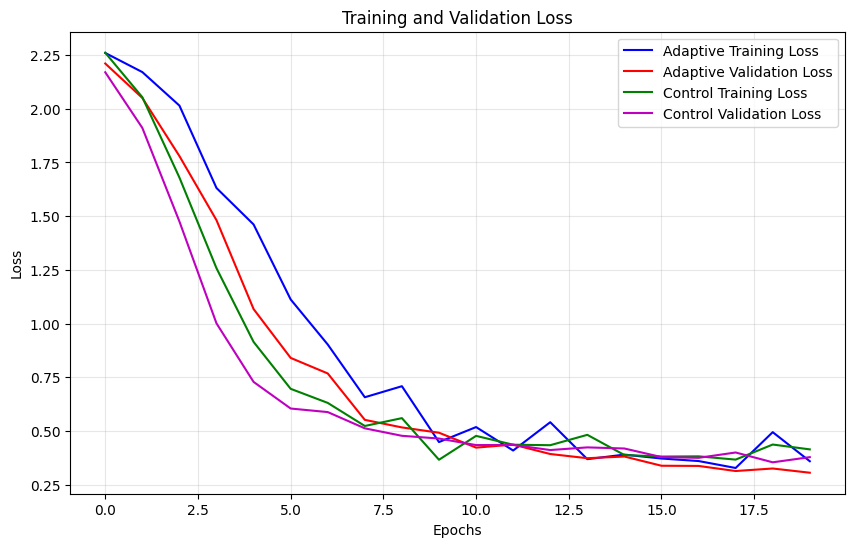

In [29]:
# 1. Plot training and validation loss
plt.figure(figsize=(10, 6))

plt.plot(history['epochs'], history['train_loss'], 'b-', label='Adaptive Training Loss')
plt.plot(history['epochs'], history['val_loss'], 'r-', label='Adaptive Validation Loss')

plt.plot(c_history['epochs'], c_history['train_loss'], 'g-', label='Control Training Loss')
plt.plot(c_history['epochs'], c_history['val_loss'], 'm-', label='Control Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

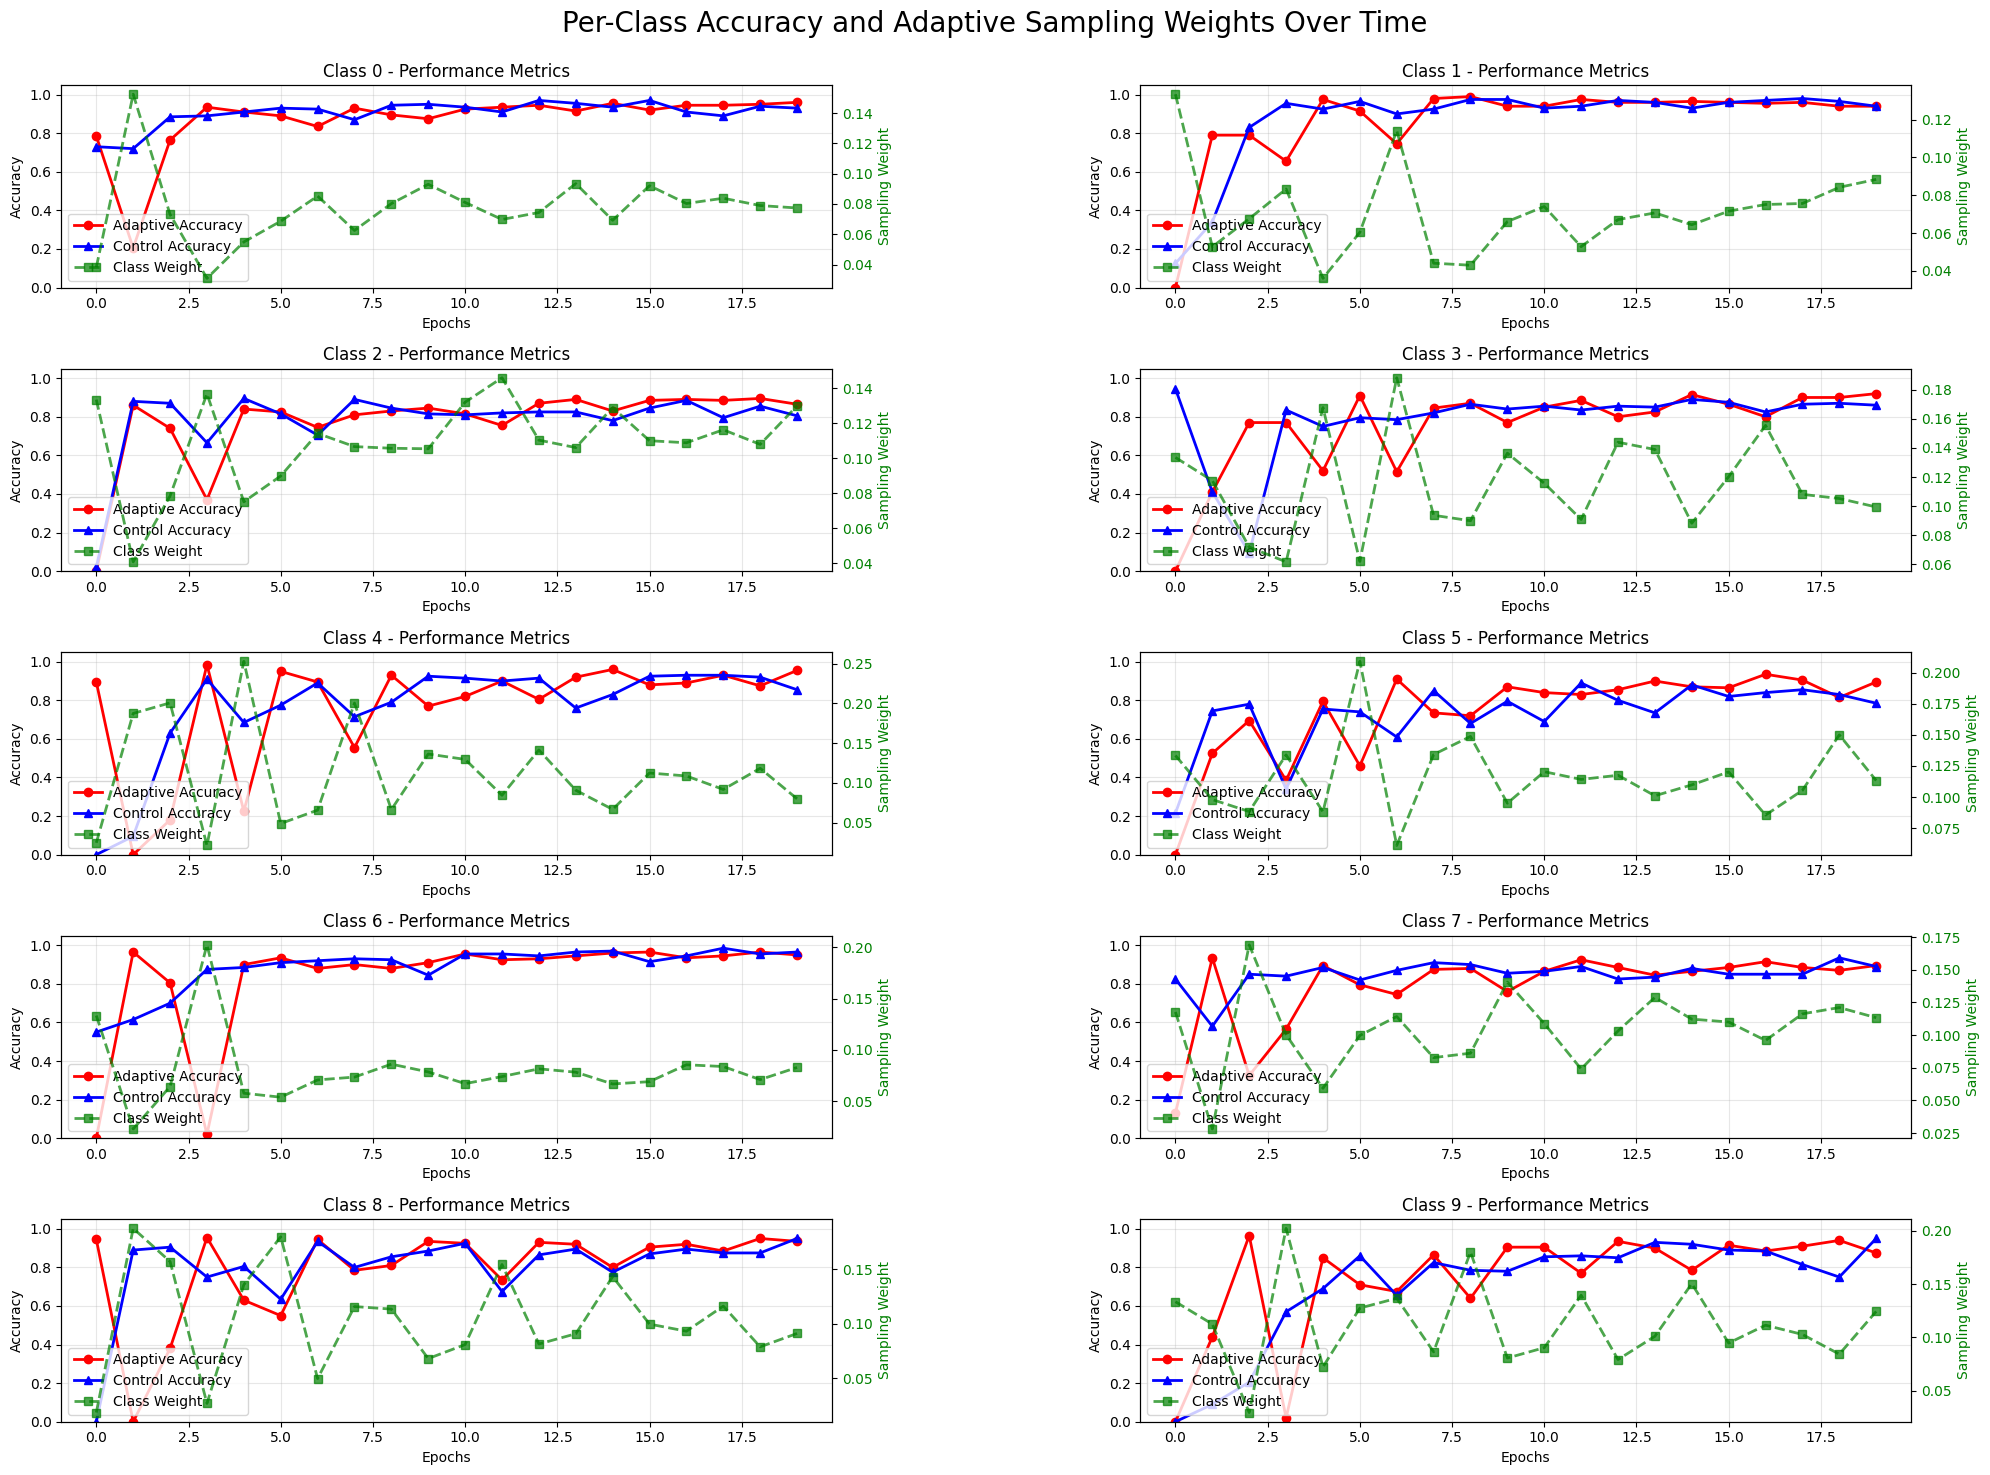

In [30]:
# 2. Plot per-class accuracy

from matplotlib.gridspec import GridSpec

# Convert data to numpy arrays for easier manipulation
acc_array = np.array(history['class_accuracies'])
c_acc_array = np.array(c_history['class_accuracies'])
weights_array = np.array(history['class_weights'])
epochs = np.array(history['epochs'])

# Create a figure with subplots for each digit (0-9)
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(5, 2, figure=fig)

# Create twin y-axis plots for each class
for i in range(10):
    ax1 = fig.add_subplot(gs[i//2, i%2])

    # Plot accuracy for both models
    ax1.plot(epochs, acc_array[:, i], 'r-', marker='o', markersize=6,
             label='Adaptive Accuracy', linewidth=2)
    ax1.plot(epochs, c_acc_array[:, i], 'b-', marker='^', markersize=6,
             label='Control Accuracy', linewidth=2)
    ax1.set_ylim(0, 1.05)  # Accuracy ranges from 0 to 1
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.grid(True, alpha=0.3)

    # Create twin y-axis for weights
    ax2 = ax1.twinx()
    ax2.plot(epochs, weights_array[:, i], 'g--', marker='s', markersize=6,
             label='Class Weight', linewidth=2, alpha=0.7)
    ax2.set_ylabel('Sampling Weight', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Set title for each subplot
    ax1.set_title(f'Class {i} - Performance Metrics')

    # Add combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower left')

plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.4)  # Add space between subplots
plt.suptitle('Per-Class Accuracy and Adaptive Sampling Weights Over Time', fontsize=20)
plt.subplots_adjust(top=0.93)  # Make room for the title
plt.show()

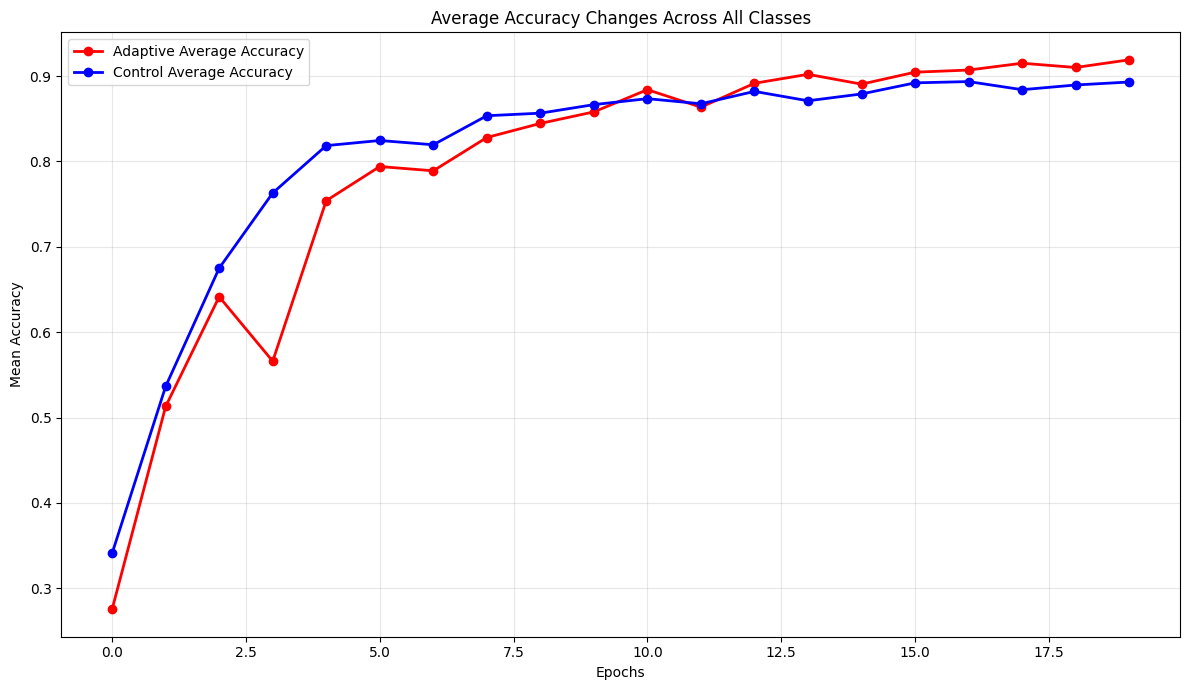

In [31]:
# 4. Plot mean accuracy over time

acc_array   = np.array(history['class_accuracies'])
c_acc_array = np.array(c_history['class_accuracies'])

plt.figure(figsize=(12, 7))

# Calculate mean accuracy across all classes for each epoch
mean_acc   = np.mean(acc_array, axis=1)
c_mean_acc = np.mean(c_acc_array, axis=1)

plt.plot(history['epochs'], mean_acc,   'r-', linewidth=2, marker='o', label='Adaptive Average Accuracy')
plt.plot(history['epochs'], c_mean_acc, 'b-', linewidth=2, marker='o', label='Control Average Accuracy')

plt.title('Average Accuracy Changes Across All Classes')
plt.xlabel('Epochs')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

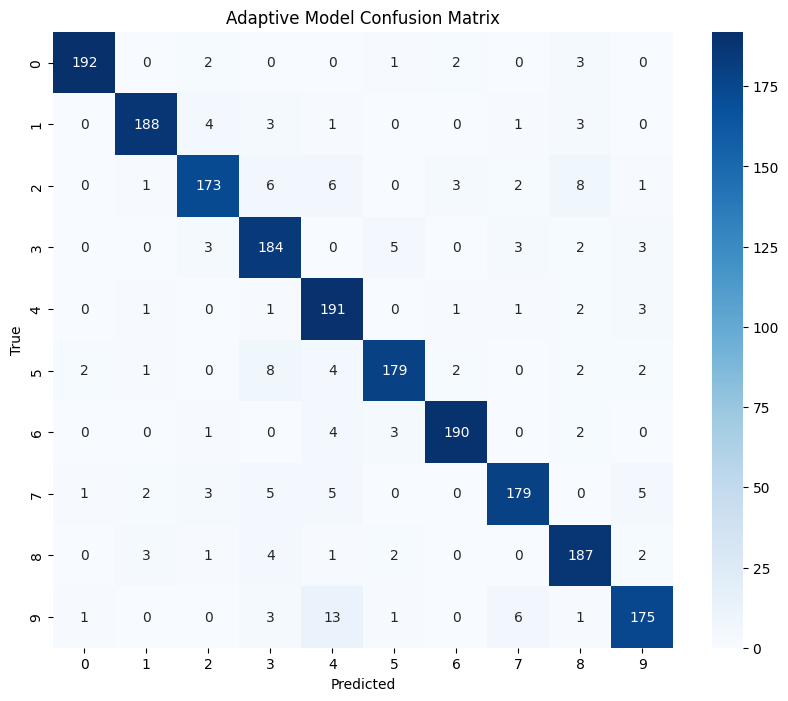

Overall Accuracy: 0.9190


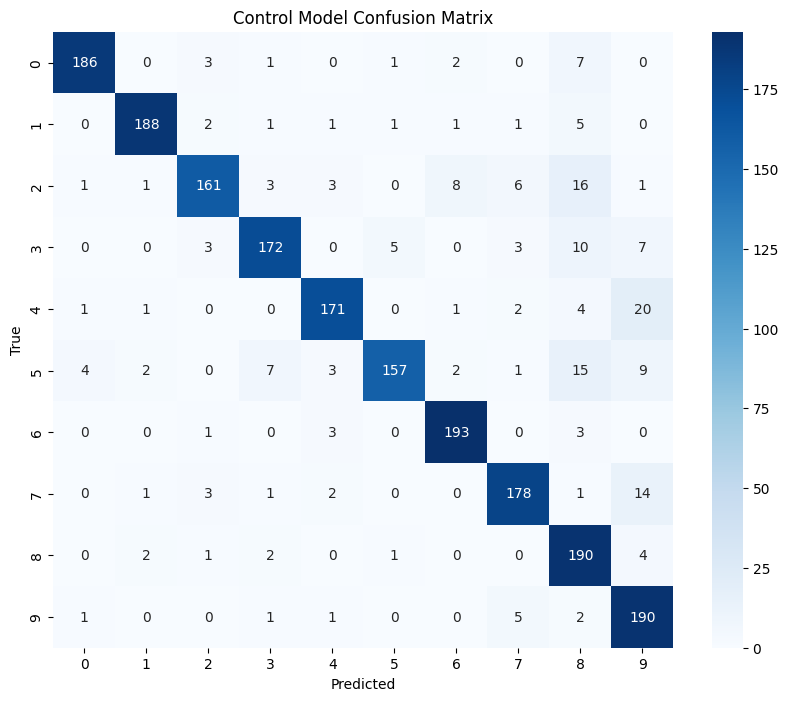

Overall Accuracy: 0.8930


In [32]:
# 5. Plot confusion matrix (at the end of training)

def plot_confusion_matrix(model, inputs, labels, device, title="Confusion Matrix"):
    """
    Generate and plot a confusion matrix for model evaluation.
    """
    model.eval()

    with torch.no_grad():
        # run inference on validation set
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        # get predictions and true labels
        y_pred = predicted.cpu().numpy()
        y_true = labels.cpu().numpy()

        # create and plot confuion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=range(10),
                    yticklabels=range(10))
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title)
        plt.show()

        # get accuracy from confusion matrix
        accuracy = np.trace(cm) / np.sum(cm)
        print(f"Overall Accuracy: {accuracy:.4f}")

plot_confusion_matrix(cnn, v_inputs, v_labels, device, "Adaptive Model Confusion Matrix")
plot_confusion_matrix(c_cnn, v_inputs, v_labels, device, "Control Model Confusion Matrix")